# Text analysis

In [93]:
# from get_links import links_on_page
import numpy as np
import pandas as pd
import requests
import re
import networkx as nx
import matplotlib.pyplot as plt
import nltk
import sklearn
from bs4 import BeautifulSoup
from tqdm import tqdm
tqdm.pandas()
from animal_list import names_from_table
from netwulf import visualize
from wordcloud import WordCloud
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

### Load in datasets from data directory

In [133]:
# aniamal names is the 228 original animals from the wikipedia page (https://en.wikipedia.org/wiki/List_of_animal_names)
animal_names = names_from_table()
animal_names_set = set(animal_names.values())
# lower case all names
animal_names_set = set([x.lower() for x in animal_names_set])

# read txt file with pandas
animal_df = pd.read_csv('data/animal_links.txt', header=None)
animal_df.columns = ['page-name']

# remove the first part of the url
animal_df['page-name'] = animal_df['page-name'].str.replace('https://en.wikipedia.org', '', regex=False)
animal_df["name"] = animal_df["page-name"].str.split("/").str[-1]

# lower case everything
animal_df["name"] = animal_df["name"].str.lower()
animal_df["page-name"] = animal_df["page-name"].str.lower()

print(f"Snippet of wikipedia list of names : {list(animal_names.values())[0:5]}")
print(f"animal_df.shape: {animal_df.shape}")

Snippet of wikipedia list of names : ['Aardvark', 'Albatross', 'Alligator', 'Alpaca', 'Ant']
animal_df.shape: (31754, 2)


In [95]:
# load in reptile dataset just for testing purposes
with open('data/data_plain_reptile.pickle', 'rb') as handle:
    pa = pickle.load(handle)
with open('data/data_plain_long_reptile.pickle', 'rb') as handle:
    pb = pickle.load(handle)
with open("data/Reptile_attributes.pickle", "rb") as handle:
    reptile_attributes = pickle.load(handle)

# make all keys lowercase
reptile_attributes = {k.lower(): v for k, v in reptile_attributes.items()}



### Helper functions

In [96]:
# create function that will run on each row in the dataframe, which will take the page name and return all the readable text on the page
def get_text(page_name):
    url = 'https://en.wikipedia.org' + page_name
    response = requests.get(url)
    html_content = response.content
    soup = BeautifulSoup(html_content, 'html.parser')
    # Find all the paragraphs in the body
    paragraphs = soup.body.find_all('p')
    # Extract the text from the paragraphs but remove \n
    # text = [p.text for p in paragraphs]
    text = [str(p.text.replace('\n', '')).strip() for p in paragraphs]
    # Join the paragraphs together
    joined_text = ' '.join(text)
    # remove first space
    joined_text = joined_text[1:]
    return joined_text

def get_links(name):
    # we look up in the reptile_long dataset
    name = name.capitalize()
    links = []
    for key, value in pb.items():
        if key[0] == name:
            links.append(key[1].lower())
        elif key[1] == name:
            links.append(key[0].lower())
    return links

def get_family(name):
    try:
        family = reptile_attributes[name]["Family:"]
    except KeyError as e: # if we cant find the family, we return unknown
        # print(f"error at {name}")
        family = "Unknown"
    return family.lower()
    

# function that can be passed to the tf-idf vectorizer that will preprocess the text. The preprocessing is to make everything lowercase and remove numbers
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text

# function we will apply to the tf-idf matrix to get the top n words
def get_top_words(row, n=300):
    return row.sort_values(ascending=False).head(n).to_dict()

# generate wordcloud
def generate_wordcloud(tf_idf:dict, title:str = "Default text"):
    wordcloud = WordCloud(width=800, height=400, background_color='white')
    wordcloud.generate_from_frequencies(tf_idf)
    plt.figure(figsize=(12,6))
    plt.title(f"Node: {title}", fontsize=20)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.savefig(f'figures/{title}_wordcloud.png', dpi=300, bbox_inches='tight')
    plt.show()

def print_function(dict, n):
    for index, (key, val) in enumerate(dict.items()):
        if index > n-1:
            break
        print((key, val))
    

In [97]:
# we will define a function to do all the steps above - tf-idf, get top words and return a dictionary with this information

def get_information_dict(filepath:str, load=True, save=False, preprocess=True, links=True, family=True) -> dict:
    """
    Function that will read a parquet file, or csv file, or json file, or pickle file, and return a dictionary with the dataframe, top words and tf-idf matrix

    Parameters
    ----------
    filepath : str
        The name of the file to read
    load : bool, optional
        Whether to load the file or not. The default is True. Can only be used if the file is already made, have to have run with save as True before
    save : bool, optional
        Whether to save the file or not. The default is False
    preprocess : bool, optional
        Whether to preprocess the text or not. The default is True
    links : bool, optional
        Whether to get the links or not. The default is True
    family : bool, optional
        Whether to get the family or not. The default is True
    
    Returns
    -------
    dict
        A dictionary with the dataframe, top words and tf-idf matrix
    """
    
    print(f"Reading {filepath}")
    # get the filepath before the extension
    filepath_without_extension = filepath.split('.')[0]
    if filepath.endswith('.parquet'):
        df = pd.read_parquet(filepath)
    elif filepath.endswith('.csv'):
        df = pd.read_csv(filepath)
    elif filepath.endswith('.json'):
        df = pd.read_json(filepath)
    elif filepath.endswith('long_reptile.pickle'):
        with open('data/data_plain_long_reptile.pickle', 'rb') as handle:
            a = pickle.load(handle)
        b = {str(k[0]).lower() for k, v in a.items()}
        c = {str(k[1]).lower() for k, v in a.items()}
        d = b.union(c)
        df = animal_df[animal_df['name'].isin(d)].reset_index(drop=True)

    elif filepath.endswith('reptile.pickle'):
        with open('data/data_plain_reptile.pickle', 'rb') as handle:
            a = pickle.load(handle)
        b = {str(k[0]).lower(): v for k, v in a.items()}
        df = animal_df[animal_df['page-name'].isin(b.keys())].reset_index(drop=True)
    
    if load:
        try:
            df = pd.read_parquet(filepath_without_extension + '.parquet')
        except FileNotFoundError:
            print(f"File {filepath} not found")
            return
    else:
        # get the text from the page
        print(f"Getting text")
        df['text'] = df['page-name'].progress_apply(get_text)

    if links:
        # Links column that shows which animals the given animal links to
        print(f"Getting links")
        df['links'] = df['name'].progress_apply(get_links)
    else:
        # check if there is a links column, if there is, drop it
        if 'links' in df.columns:
            df.drop('links', axis=1, inplace=True)
    if family:
        # Family column that shows which family the given animal belongs to
        print(f"Getting family")
        df['family'] = df['name'].progress_apply(get_family)

    if save:
        # save as parquet file
        df.to_parquet(filepath_without_extension + '.parquet')
    

    # we use sklearn's tf-idf vectorizer to get the tf-idf matrix. This is a more efficient way of doing it, as the function is optimized.
    if preprocess:
        vectorizer = TfidfVectorizer(stop_words='english', dtype=np.float32, preprocessor=preprocess_text)
    else:
        vectorizer = TfidfVectorizer(stop_words='english', dtype=np.float32)
    
    tfidf_matrix = vectorizer.fit_transform(df['text'])
    feature_names = vectorizer.get_feature_names_out()
    tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns=feature_names)
    
    print(f"Getting top words")
    top_words = tfidf_df.progress_apply(get_top_words, axis=1)
    top_words.index = df['name']

    if save:
        # save as a json file
        top_words.to_json(filepath_without_extension + '_top_words.json')
    
    return {'df': df, 'top_words': top_words, 'tfidf_df': tfidf_df}
    

The naming convention is exaplained below and it quite important to follow the analysis we go through further down

In [134]:
# This is where we pretty much execute all the code defined above for both datasets

# This is the dataset where we have gathered all the links between all the animals in the ADW dataset
data_dict_reptile_long = get_information_dict('data/data_plain_long_reptile.pickle', load=True, save=True, preprocess=True)


# This is the dataset where we have gone through all the animals in the dataset and gathered the links between them an the orignal animal dataset consting of the "main" animals from the wikipedia list of animals
data_dict_reptile = get_information_dict('data/data_plain_reptile.pickle', load=True, save=True, preprocess=True, links=False, family=True)


Reading data/data_plain_long_reptile.pickle
Getting links


100%|██████████| 1063/1063 [00:02<00:00, 397.54it/s]


Getting family


100%|██████████| 1063/1063 [00:00<00:00, 267925.31it/s]


Getting top words


100%|██████████| 1063/1063 [00:01<00:00, 693.35it/s]


Reading data/data_plain_reptile.pickle
Getting family


100%|██████████| 4344/4344 [00:00<00:00, 973397.62it/s]


Getting top words


100%|██████████| 4344/4344 [00:08<00:00, 542.19it/s]


In [99]:
data_dict_reptile["df"]

,page-name,name,text,family
0,/wiki/chironius_laurenti,chironius_laurenti,Chironius laurenti is a species of nonvenomous...,colubridae
1,/wiki/dasia_olivacea,dasia_olivacea,"Dasia olivacea, the olive dasia or olive tree ...",scincidae
2,/wiki/alabama_map_turtle,alabama_map_turtle,The Alabama map turtle (Graptemys pulchra) is ...,emydidae
3,/wiki/geoscincus,geoscincus,Geoscincus is a monotypic genus of skinks: the...,scincidae
4,/wiki/gonyosoma_oxycephalum,gonyosoma_oxycephalum,"Elaphe oxycephala (Boie, 1827) Gonyosoma oxyce...",colubridae
...,...,...,...,...
4339,/wiki/eugongylus_albofasciolatus,eugongylus_albofasciolatus,The white-striped cape skink or barred shark s...,scincidae
4340,/wiki/eumecia_johnstoni,eumecia_johnstoni,Eumecia johnstoni is a species of skink found ...,scincidae
4341,/wiki/giant_plated_lizard,giant_plated_lizard,The giant plated lizard (Matobosaurus validus)...,gerrhosauridae
4342,/wiki/eutropis_multicarinata,eutropis_multicarinata,Eutropis multicarinata is a species of skink f...,scincidae


### Analysis of the reptile df with links back to the 228 long animal list

In [100]:
# We want to check the score of the words in the top words for each animal
# We will do this by getting the tf-idf score for each word in the top words for each animal


for name, top_words in data_dict_reptile['top_words'].items():
    tw_keys = set([k for k, value in top_words.items() if value > 0]) # get the keys of the top words that have a score > 0

    links = list(animal_names_set.intersection(tw_keys))
    if links:
        link_dict = {name: {k: top_words[k]} for k in links}
        
        # add to the df
        data_dict_reptile['df'].loc[data_dict_reptile['df']['name'] == name, 'links'] = str(link_dict[name])

In [101]:
# We now see a links column where we can see which main animals the pages mention, and the tf-idf score
data_dict_reptile["df"]

,page-name,name,text,family,links
0,/wiki/chironius_laurenti,chironius_laurenti,Chironius laurenti is a species of nonvenomous...,colubridae,NaN
1,/wiki/dasia_olivacea,dasia_olivacea,"Dasia olivacea, the olive dasia or olive tree ...",scincidae,{'skink': 0.05847395211458206}
2,/wiki/alabama_map_turtle,alabama_map_turtle,The Alabama map turtle (Graptemys pulchra) is ...,emydidae,{'turtle': 0.27575668692588806}
3,/wiki/geoscincus,geoscincus,Geoscincus is a monotypic genus of skinks: the...,scincidae,{'skink': 0.11515277624130249}
4,/wiki/gonyosoma_oxycephalum,gonyosoma_oxycephalum,"Elaphe oxycephala (Boie, 1827) Gonyosoma oxyce...",colubridae,NaN
...,...,...,...,...,...
4339,/wiki/eugongylus_albofasciolatus,eugongylus_albofasciolatus,The white-striped cape skink or barred shark s...,scincidae,{'shark': 0.2785531282424927}
4340,/wiki/eumecia_johnstoni,eumecia_johnstoni,Eumecia johnstoni is a species of skink found ...,scincidae,{'skink': 0.22512587904930115}
4341,/wiki/giant_plated_lizard,giant_plated_lizard,The giant plated lizard (Matobosaurus validus)...,gerrhosauridae,{'lizard': 0.22714518010616302}
4342,/wiki/eutropis_multicarinata,eutropis_multicarinata,Eutropis multicarinata is a species of skink f...,scincidae,{'skink': 0.2291412651538849}


![alternatvie text](figures/network.png)

Above the graph of the network can be seen for the file data_plain_reptile which tracks how many times all the pages refer back to the 224 long list of animals (main animals). We see a clear clustering around the nodes: Lizard, Skink, Turtle, Snake and Gecko to name the largest. Let us investigate if we can see a link for some of the nodes in these clusters through our text analysis


We will look at the animal laudakia dayana which can faintly be seen in the lizard cluster.
The result can be seen below where lizard comes in at the 20th place according to tf-idf score and can also be seen in the wordcloud

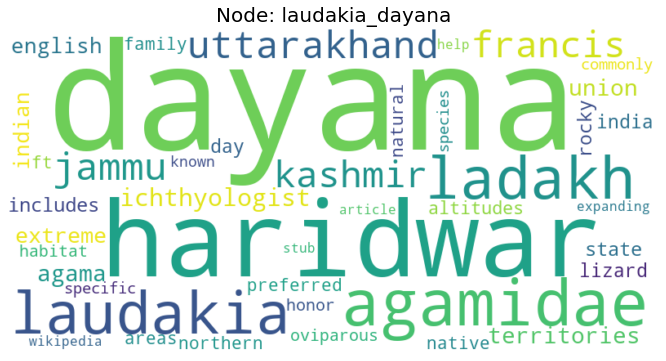

('dayana', 0.7781180739402771)
('haridwar', 0.3264921307563782)
('agamidae', 0.17940571904182434)
('ladakh', 0.14602045714855194)
('laudakia', 0.14602045714855194)
('jammu', 0.137184739112854)
('uttarakhand', 0.1349705010652542)
('francis', 0.12666435539722443)
('kashmir', 0.12536734342575073)
('ichthyologist', 0.12415406852960587)
('territories', 0.10556888580322266)
('agama', 0.1051366925239563)
('union', 0.10199619829654694)
('extreme', 0.09168355166912079)
('indian', 0.08808277547359467)
('english', 0.08808277547359467)
('includes', 0.07648512721061707)
('state', 0.07445795089006424)
('rocky', 0.07048151642084122)
('day', 0.06949358433485031)
('lizard', 0.06937794387340546)
('india', 0.06880073249340057)
('altitudes', 0.06345445662736893)
('areas', 0.05691749230027199)
('native', 0.05564678832888603)


In [117]:
sample_name = 'laudakia_dayana'
generate_wordcloud(data_dict_reptile["top_words"][sample_name], sample_name)
# print top 20 elements in the dictionary
print_function(data_dict_reptile["top_words"][sample_name], 25)

Let us investigate another one. This time geophis fulvoguttatus which can be seen in the snake cluster
Our hypothesis is that it also can be seen in the wordcloud and in the td-idf score

The wordcloud and the top words below indicate that there is quite a strong connection with this sample to snake, being the 3rd highest ranked. But we also see that there is not many words on the page at all, only about 15 in total

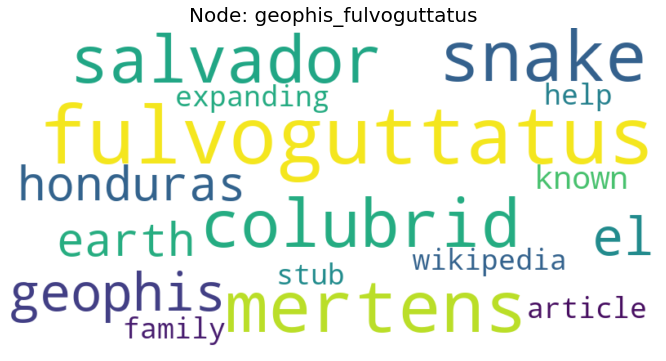

('fulvoguttatus', 0.44143447279930115)
('mertens', 0.3592900335788727)
('snake', 0.3421878516674042)
('colubrid', 0.3206845819950104)
('salvador', 0.3119744658470154)
('geophis', 0.2958552837371826)
('el', 0.2914089560508728)
('honduras', 0.2734665274620056)
('earth', 0.2560710310935974)
('known', 0.09993358701467514)
('wikipedia', 0.07793111354112625)
('stub', 0.07791164517402649)
('expanding', 0.0777173787355423)
('article', 0.07762051373720169)
('family', 0.07683277130126953)
('help', 0.07669943571090698)
('peyriéras', 0.0)
('peyrierasi', 0.0)
('peyrieras', 0.0)
('petén', 0.0)
('petty', 0.0)
('petteri', 0.0)
('petted', 0.0)
('petsmart', 0.0)
('pets', 0.0)


In [118]:
sample_name = 'geophis_fulvoguttatus'
generate_wordcloud(data_dict_reptile["top_words"][sample_name], sample_name)
print_function(data_dict_reptile["top_words"][sample_name], 25)

And lastly the northern yellow-faced turtle

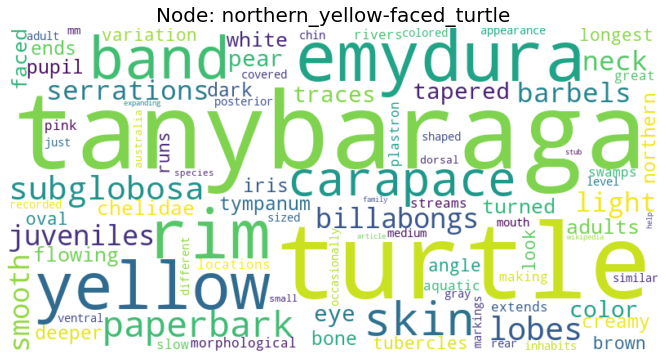

('tanybaraga', 0.2811693549156189)
('turtle', 0.2727622985839844)
('emydura', 0.23628221452236176)
('rim', 0.22315356135368347)
('yellow', 0.20823559165000916)
('band', 0.1625460535287857)
('carapace', 0.15323114395141602)
('skin', 0.1429198533296585)
('paperbark', 0.14058467745780945)
('subglobosa', 0.1340203583240509)
('lobes', 0.12936289608478546)
('juveniles', 0.1272517740726471)
('billabongs', 0.12575028836727142)
('smooth', 0.12483227998018265)
('light', 0.12070350348949432)
('serrations', 0.12030293047428131)
('barbels', 0.11814110726118088)
('neck', 0.11724644154310226)
('tapered', 0.11623424291610718)
('eye', 0.11574481427669525)
('pear', 0.11452849954366684)
('traces', 0.11452849954366684)
('color', 0.1111048012971878)
('flowing', 0.11028092354536057)
('adults', 0.10865684598684311)


In [123]:
sample_name = "northern_yellow-faced_turtle"
generate_wordcloud(data_dict_reptile["top_words"][sample_name], sample_name)
print_function(data_dict_reptile["top_words"][sample_name], 25)

It is clear from the tf-idf scores and wordclouds above that tf-idf is a good measure if you are asked to describe what the wikiepedia page is about, and what words most accuratly describe the animal you are looking at. We also see a clear correlation between the animal and the "parent animal" having a high td-idf score, where with parent animal for i.e the northern_yellow-faced_turtle, i mean turtle. which we can see right above gets the 4.th place in tf-idf ranking

### Analysis of the reptile df long (references to each other)

In [124]:
data_dict_reptile_long["df"]

,page-name,name,links,text,family
0,/wiki/alabama_map_turtle,alabama_map_turtle,"[d%27orbigny%27s_slider, jamaican_slider, yell...",The Alabama map turtle (Graptemys pulchra) is ...,emydidae
1,/wiki/geoscincus,geoscincus,[geoscincus],Geoscincus is a monotypic genus of skinks: the...,scincidae
2,/wiki/gharial,gharial,"[chinese_alligator, cuvier%27s_dwarf_caiman, m...","The gharial (Gavialis gangeticus), also known ...",gavialidae
3,/wiki/desert_rosy_boa,desert_rosy_boa,[calabar_python],The desert rosy boa (Lichanura trivirgata) is ...,boidae
4,/wiki/oriental_garden_lizard,oriental_garden_lizard,"[bronchocela_cristatella, common_house_gecko, ...",The oriental garden lizard (Calotes versicolor...,agamidae
...,...,...,...,...,...
1058,/wiki/bothrops_jararaca,bothrops_jararaca,"[philodryas_patagoniensis, philodryas_olfersii...",Bothrops jararaca — known as the jararaca[4] o...,viperidae
1059,/wiki/dipsas_temporalis,dipsas_temporalis,[dipsas_pakaraima],"Dipsas temporalis, the temporal snail-eater, i...",colubridae
1060,/wiki/djokoiskandarus,djokoiskandarus,[djokoiskandarus],"Cantoria annulata de Jong, 1926 Djokoiskandaru...",homalopsidae
1061,/wiki/hosmer%27s_spiny-tailed_skink,hosmer%27s_spiny-tailed_skink,[cunningham%27s_spiny-tailed_skink],Hosmer's spiny-tailed skink or Hosmer's skink ...,scincidae


Let us look at some samples from the dataframe from above and see if we can see some links in the wordcloud

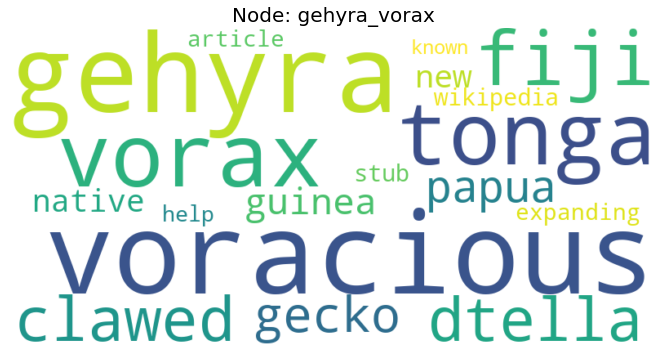

('voracious', 0.511308491230011)
('gehyra', 0.46555832028388977)
('vorax', 0.2916136682033539)
('tonga', 0.2794044017791748)
('fiji', 0.24498844146728516)
('clawed', 0.24051693081855774)
('dtella', 0.24051693081855774)
('gecko', 0.23760585486888885)
('papua', 0.1968197375535965)
('guinea', 0.15388727188110352)
('new', 0.10991539806127548)
('native', 0.10207996517419815)
('wikipedia', 0.08831419050693512)
('stub', 0.08831419050693512)
('expanding', 0.08749913424253464)
('article', 0.08681275695562363)
('help', 0.08199091255664825)
('known', 0.06407976150512695)
('physical', 0.0)
('phylogenic', 0.0)
('phylogeny', 0.0)
('phylogeographic', 0.0)
('phylogeographical', 0.0)
('phylum', 0.0)
('physaloptera', 0.0)


In [125]:
sample_name = "gehyra_vorax"
generate_wordcloud(data_dict_reptile_long["top_words"][sample_name], sample_name)
print_function(data_dict_reptile_long["top_words"][sample_name], 25)

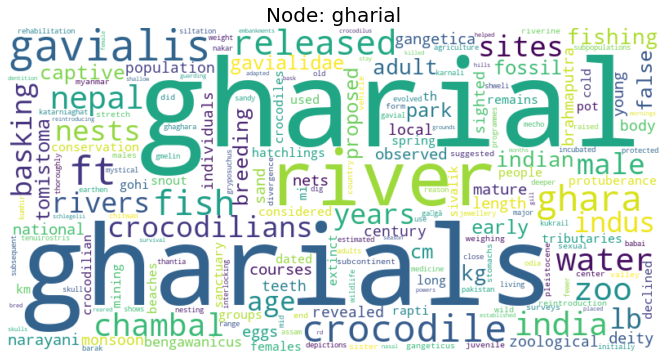

('gharial', 0.6386590003967285)
('gharials', 0.5350414514541626)
('river', 0.20244327187538147)
('gavialis', 0.11100762337446213)
('ft', 0.09877107292413712)
('crocodile', 0.0865066796541214)
('ghara', 0.07815366238355637)
('released', 0.07153294235467911)
('fish', 0.06994215399026871)
('water', 0.0636313408613205)
('zoo', 0.06326179951429367)
('nepal', 0.05965496227145195)
('india', 0.05872292444109917)
('chambal', 0.05534911900758743)
('crocodilians', 0.05516861006617546)
('male', 0.05462060123682022)
('nests', 0.054336272180080414)
('sites', 0.054135337471961975)
('rivers', 0.05029148608446121)
('years', 0.04920561984181404)
('indus', 0.0485239177942276)
('lb', 0.04816727712750435)
('basking', 0.047353364527225494)
('age', 0.04317887872457504)
('fishing', 0.04294043406844139)


In [126]:
sample_name = "gharial"
generate_wordcloud(data_dict_reptile_long["top_words"][sample_name], sample_name)
print_function(data_dict_reptile_long["top_words"][sample_name], 25)


We see the same result from the 2 above wordclouds of the reptile_long dataset where we investigate links between all the animals, as we did from the other 3 wordclouds from the other dataset. There are links to the "parent animal" i.e. from gharial to crocodile, but not to another specific animal.


Let us see if we can see a connection to the animals respective families in the text analysis:

In [107]:
# we want to to investigate if there is correlation between the top words and the animals family
# We will do this by seeing the if the links are in the top 20 top words

scores = []
for name, top_words in data_dict_reptile_long["top_words"].items():
    family = data_dict_reptile_long["df"][data_dict_reptile_long["df"]["name"] == name]["family"].values[0]
    
    if family in top_words:
        score = top_words[family]
    else:
        score = 0
    scores.append(score)

    
np.mean(scores)

0.05304093526015698

This is a quite bad score in general. Which makes sense, in most cases the family is only mentioned once per page, which means that it will have a quite low term frequency, while having the max or close to max inverse document frequency as we expect there atleast to be one mention of the family on a page.

It is quite evident from the text analysis that TF-IDF is a good tool is you were asked to write down some key notes, or points of an animal. This is due to the nature of weighting items that are unique to the document higher, rather than just looking at term frequency.